In [1]:
import sys
sys.path.append('/home/jonathan/Dropbox/jonathanmain/CGM/rapidCoolingCGM/pysrc')

In [2]:
import time, importlib
import pylab as pl, numpy as np, glob, pdb
from numpy import log10 as log
import astropy
from astropy import units as un, constants as cons

In [3]:
profdir = '/home/jonathan/Dropbox/jonathanmain/CGM/rapidCoolingCGM/pyobj/no_yt_analysis/'

In [4]:
simname = 'm12i'
z = 0.0016
#### change the following to location of npz file
fn = 'profiles_files/profiler_%s_md_7100_z%.4f.npz'%(simname,z)  
f = np.load(fn)

In [5]:
log_r2rvir_bins = np.arange(-3,0.5,.01)
rvir = f['rvir']
rs = 10.**((log_r2rvir_bins[1:]+log_r2rvir_bins[:-1])/2)*rvir
drs = np.pad((rs[2:]-rs[:-2])/2., 1, 'edge')

In [6]:
Mdot_highT  = -f['Mdot_hot_nodisc']
Mdot_lowT = -f['Mdot_cool_nodisc2']
Ms = np.array([f['massProfile%d'%iPartType] for iPartType in (0,1,2,4)]).sum(axis=0)
vc =((cons.G*un.Msun / un.kpc)**0.5).to('km/s').value * (Ms.cumsum() / rs)**0.5 
g = vc**2 / rs
Mdot_cool = f['rad_per_unit_mass_MW'] * f['massProfile0'] / drs / g
Mdot_cool *= (un.erg * un.s**-1 *un.g**-1 * un.Msun * (un.km/un.s)**-2).to('Msun/yr')

In [7]:
fig_width_full_pt = 513.11743  # Get this from LaTeX using \showthe\columnwidth
fig_width_half_pt = 245.26653
inches_per_pt = 1.0/72.27               # Convert pt to inch
fig_width_full = fig_width_full_pt*inches_per_pt  # width in inches
fig_width_half = fig_width_half_pt*inches_per_pt 

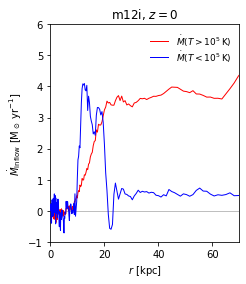

In [10]:
pl.figure(figsize=(fig_width_half,4))
ax=pl.subplot(111)
for i,Mdot in enumerate((Mdot_highT,Mdot_lowT,Mdot_cool)[:2]):
        label = (r'$\dot{M}(T>10^5\,{\rm K})$',r'$\dot{M}(T<10^5\,{\rm K})$',r'$\dot{M}_{\rm cool}$')[i]
        pl.plot(rs,Mdot,c=('r','b','grey')[i],label=label,lw=1,zorder=(10,-10)[i==2])
# pl.axhline(sfrs[1],c='.5',lw=0.5)
# pl.text(5.2,sfrs[1]+0.25,r'${\rm SFR}$')
# pl.semilogx()
# pl.axvline(rvir,c='.5',ls='-',lw=0.5)
# pl.text(rvir,9,r'$R_{\rm vir}$')
pl.axhline(0,c='.5',ls='-',lw=0.5)
pl.xlim(0,70)
pl.ylim(-1,6)
pl.xlabel(r'$r\ [{\rm kpc}]$')
pl.ylabel(r'$\dot{M}_{\rm inflow}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')
pl.legend(ncol=1,fontsize=9,loc='upper right',labelspacing=0.1,frameon=False)
pl.title(r'%s, $z=%d$'%(simname,z))
pl.savefig('figures/Mdot_%s.pdf'%simname,bbox_inches='tight')

In [109]:
def avg(arr):
    return arr[:-4].reshape(69,5).mean(axis=1)

In [176]:
r = 50
mu = 0.62
const = (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* mu)  
Mdot_cools = {}; Mdots = {}; zs = {}; tcools = {}
log_r2rvir_bins = np.arange(-3,0.5,.01)
simnames = 'm12i','m12b'
for sim in simnames:
    fns = glob.glob(profdir + 'profiler_%s_md_7100_z*.npz'%sim)
    Mdot_cools[sim] = []
    Mdots[sim] = []
    zs[sim] = []    
    tcools[sim] = []    
    for fn in fns:
        z = float(fn[fn.index('_z')+2:-4])
        if z>1: continue
        f = np.load(fn)
        rvir = f['rvir']

        rs = 10.**((log_r2rvir_bins[1:]+log_r2rvir_bins[:-1])/2)*rvir
        drs = np.pad((rs[2:]-rs[:-2])/2., 1, 'edge')
        if 'rad_per_unit_mass_MW' not in f.files: continue
        
        zs[sim].append(z)
        if z<0.001: mvir = f['mvir']
    #     Mdot_highTs.append( np.interp(30,rs,-f['Mdot_hot_nodisc']) )
#         Mdot_highTs.append( np.interp(r,rs,-f['Mdot_in']-f['Mdot_out']) )
        Mgas = f['massProfile0']
        Mdot = -Mgas *f['vrs_MW']*un.s.to('yr')**-1/drs/un.kpc.to('km')     
        eps = (f['Ts_MW']/ const)*((un.km/un.s)**2)
        tcool = (eps*((un.km/un.s)**2).to('erg/g') / f['rad_per_unit_mass_MW'])*un.s.to('Gyr')
        tcools[sim].append(np.interp(r,avg(rs),avg(tcool)))
        deps_dr = 5/3. * np.pad((eps[2:]-eps[:-2])/2., 1, 'edge')/drs
        Mdots[sim].append( np.interp(r,avg(rs),avg(Mdot)))
        Ms = np.array([f['massProfile%d'%iPartType] for iPartType in (0,1,2,4)]).sum(axis=0)
        vc =((cons.G*un.Msun / un.kpc)**0.5).to('km/s').value * (Ms.cumsum() / rs)**0.5 
        g = vc**2 / rs
        gtag = g + deps_dr
        Mdot_cool = f['rad_per_unit_mass_MW'] * f['massProfile0'] / drs / gtag
        Mdot_cool *= (un.erg * un.s**-1 *un.g**-1 * un.Msun * (un.km/un.s)**-2).to('Msun/yr')
        Mdot_cools[sim].append(np.interp(r,avg(rs),avg(Mdot_cool)))

In [177]:
mvir

array(1.30585755e+12)

In [178]:
import my_utils as u

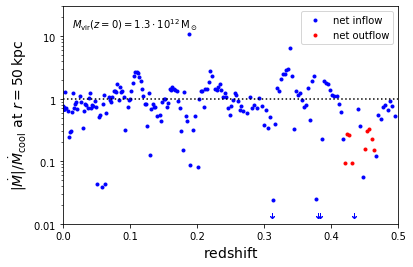

In [169]:
for i,sim in enumerate(simnames[:1]):
    ax = pl.subplot(111)
    pl.text(0.025,0.9,r'$M_{\rm vir}(z=0)=%.1f\cdot10^{12}\,{\rm M}_\odot$'%(mvir/1e12),transform=ax.transAxes)
    vals = np.abs(np.array(Mdots[sim])/np.array(Mdot_cools[sim]))
    inds0 = np.array(Mdot_cools[sim])>0
    for isInflow in True,False:
        if isInflow:
            inds = inds0 & (np.array(Mdots[sim])>0)
            c = 'b'
            label = r'net inflow'
        else:
            inds = inds0 & (np.array(Mdots[sim])<0)
            c = 'r'
            label = r'net outflow'
        pl.plot(np.array(zs[sim])[inds],vals[inds] ,'.',c=c,label=label)
        inds2 = inds & (vals<0.015)
        pl.plot(np.array(zs[sim])[inds2],[0.015]*len(vals[inds2]),ls='none',marker=u.buildMarker([180]),c=c,ms=10)
    pl.ylim(0.01,30)
    pl.xlim(0,0.5)
    pl.semilogy()
    pl.ylabel(r'$|\dot{M}|/\dot{M}_{\rm cool}\ {\rm at}\ r=50\,{\rm kpc}$',fontsize=14)
    pl.axhline(1.,c='k',ls=':')
    pl.xlabel(r'${\rm redshift}$',fontsize=14)
    ax.yaxis.set_major_formatter(u.arilogformatter)
    pl.legend()
pl.savefig('/home/jonathan/tmpdir/m12i_vs_cooling_flow.pdf')

(0, 0.5)

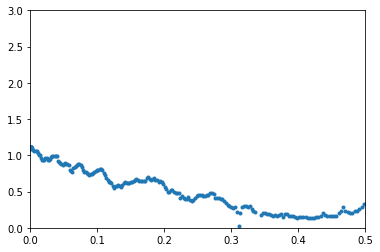

In [181]:
sim='m12i'
pl.plot(zs[sim],tcools[sim],'.')
pl.ylim(0,3)
pl.xlim(0,0.5)

In [4]:
Mdot_highT  = -f['Mdot_hot_nodisc']
Mdot_lowT = -f['Mdot_cool_nodisc2']
Ms = np.array([f['massProfile%d'%iPartType] for iPartType in (0,1,2,4)]).sum(axis=0)
vc =((cons.G*un.Msun / un.kpc)**0.5).to('km/s').value * (Ms.cumsum() / rs)**0.5 
g = vc**2 / rs
Mdot_cool = f['rad_per_unit_mass_MW'] * f['massProfile0'] / drs / g
Mdot_cool *= (un.erg * un.s**-1 *un.g**-1 * un.Msun * (un.km/un.s)**-2).to('Msun/yr')

In [5]:
fig_width_full_pt = 513.11743  # Get this from LaTeX using \showthe\columnwidth
fig_width_half_pt = 245.26653
inches_per_pt = 1.0/72.27               # Convert pt to inch
fig_width_full = fig_width_full_pt*inches_per_pt  # width in inches
fig_width_half = fig_width_half_pt*inches_per_pt 

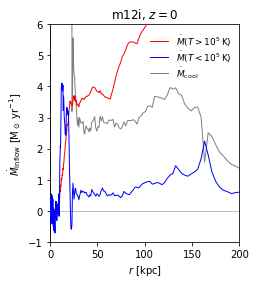

In [7]:
pl.figure(figsize=(fig_width_half,4))
ax=pl.subplot(111)
for i,Mdot in enumerate((Mdot_highT,Mdot_lowT,Mdot_cool)):
        label = (r'$\dot{M}(T>10^5\,{\rm K})$',r'$\dot{M}(T<10^5\,{\rm K})$',r'$\dot{M}_{\rm cool}$')[i]
        pl.plot(rs,Mdot,c=('r','b','grey')[i],label=label,lw=1,zorder=(10,-10)[i==2])
# pl.axhline(sfrs[1],c='.5',lw=0.5)
# pl.text(5.2,sfrs[1]+0.25,r'${\rm SFR}$')
# pl.semilogx()
# pl.axvline(rvir,c='.5',ls='-',lw=0.5)
# pl.text(rvir,9,r'$R_{\rm vir}$')
pl.axhline(0,c='.5',ls='-',lw=0.5)
pl.xlim(0,200)
pl.ylim(-1,6)
pl.xlabel(r'$r\ [{\rm kpc}]$')
pl.ylabel(r'$\dot{M}_{\rm inflow}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')
pl.legend(ncol=1,fontsize=9,loc='upper right',labelspacing=0.1,frameon=False)
pl.title(r'%s, $z=%d$'%(simname,z))
pl.savefig('figures/Mdot_%s.pdf'%simname,bbox_inches='tight')